 # EDA Submission & Methodology Submission-William Thompson

# NBA GAME STATISTICS

# Importing libraries

In [362]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display, Markdown

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Loading Datasets 

In [365]:

games_data= pd.read_csv('games.csv')
games_details_data= pd.read_csv('games_details.csv')
players_data = pd.read_csv('players.csv')
ranking_data = pd.read_csv('ranking.csv')
teams_data = pd.read_csv('teams.csv')


These data sets are from Kaggle. These datasets are from 2003 to 2019. The games.csv gives an overall summary of all the games during that time, while the games details data set gives the individual player statistics for each game. The players data set shows all the players in the NBA from 2003 to 2019. The ranking data set shows the performance of the teams like how many games they won and lost. The teams data just gives a list of all of the teams in the NBA

https://www.kaggle.com/code/nathanlauga/nba-games-eda-let-s-dive-into-the-data/input

# Data Wrangling

In [369]:
games_data = games_data.dropna()

In [371]:
players_data = players_data.dropna()

In [373]:
ranking_data['SEASON'] = ranking_data['SEASON_ID'].astype(str).str[1:]

ranking_data = ranking_data.dropna()


ranking_data = ranking_data[ranking_data['G'] >= 82]

ranking_data['STANDINGSDATE'] = pd.to_datetime(ranking_data['STANDINGSDATE'])


ranking_data = ranking_data.sort_values(by=['TEAM', 'SEASON_ID', 'STANDINGSDATE'])


ranking_data = ranking_data.drop_duplicates(subset=['TEAM', 'SEASON_ID'], keep='last')


print(ranking_data.head()) 

#ranking_data.to_csv('better_ranking_data.csv', index=False)

           TEAM_ID  LEAGUE_ID  SEASON_ID STANDINGSDATE CONFERENCE     TEAM   G   W   L  W_PCT HOME_RECORD ROAD_RECORD SEASON
149888  1610612737          0      22002    2003-10-04       East  Atlanta  82  35  47  0.427       26-15        9-32   2002
144294  1610612737          0      22003    2004-10-11       East  Atlanta  82  28  54  0.341       18-23       10-31   2003
138852  1610612737          0      22004    2005-10-09       East  Atlanta  82  13  69  0.159        9-32        4-37   2004
133450  1610612737          0      22005    2006-10-04       East  Atlanta  82  26  56  0.317       18-23        8-33   2005
127960  1610612737          0      22006    2007-10-05       East  Atlanta  82  30  52  0.366       18-23       12-29   2006


This data set posted the teams rankings every day, so i first removed all rankings that had less than 82 games. 
Then, I dropped all duplicates of rows with the same team name and seasonID.

In [376]:
teams_data = teams_data.drop(columns=['ARENACAPACITY'])

This was the only column with null values and it's unimportant so i got rid of it.

In [379]:
games_details_data = games_details_data.drop(columns=['COMMENT'])

Here I removed the Comment column because most of them were empty and would take away a lot of usable rows. 

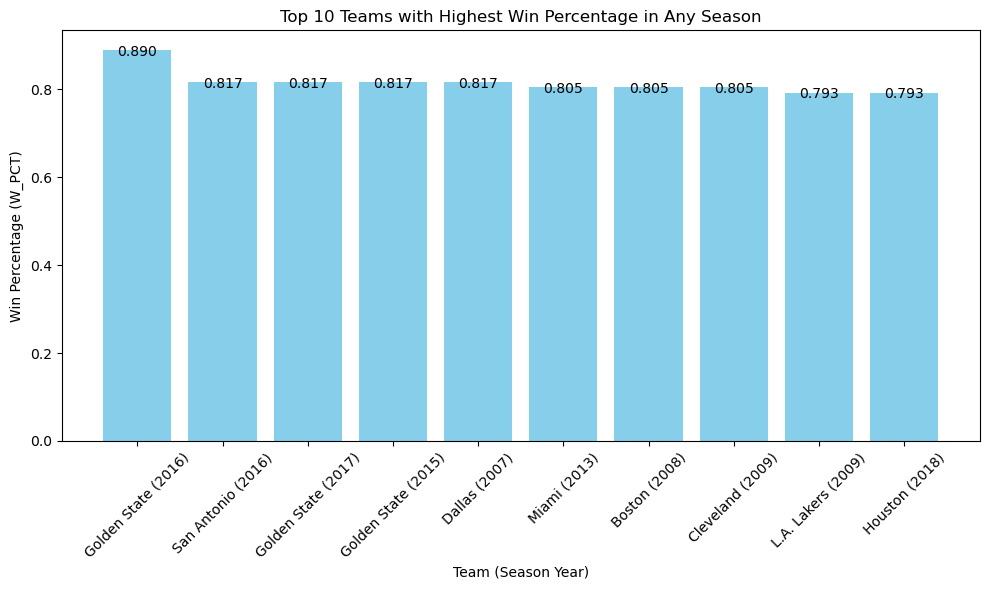

In [383]:
top_teams = ranking_data.sort_values(by='W_PCT', ascending=False).head(10)


top_teams['season_year'] = top_teams['STANDINGSDATE'].astype(str).str[:4]


top_teams['team_season'] = top_teams['TEAM'] + ' (' + top_teams['season_year'] + ')'


plt.figure(figsize=(10, 6))
bars = plt.bar(top_teams['team_season'], top_teams['W_PCT'], color='skyblue')


for bar, pct in zip(bars, top_teams['W_PCT']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{pct:.3f}', 
             ha='center', va='bottom', color='black')

plt.xlabel('Team (Season Year)')
plt.ylabel('Win Percentage (W_PCT)')
plt.title('Top 10 Teams with Highest Win Percentage in Any Season')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

These are the 10 teams with the highest win percentage. 

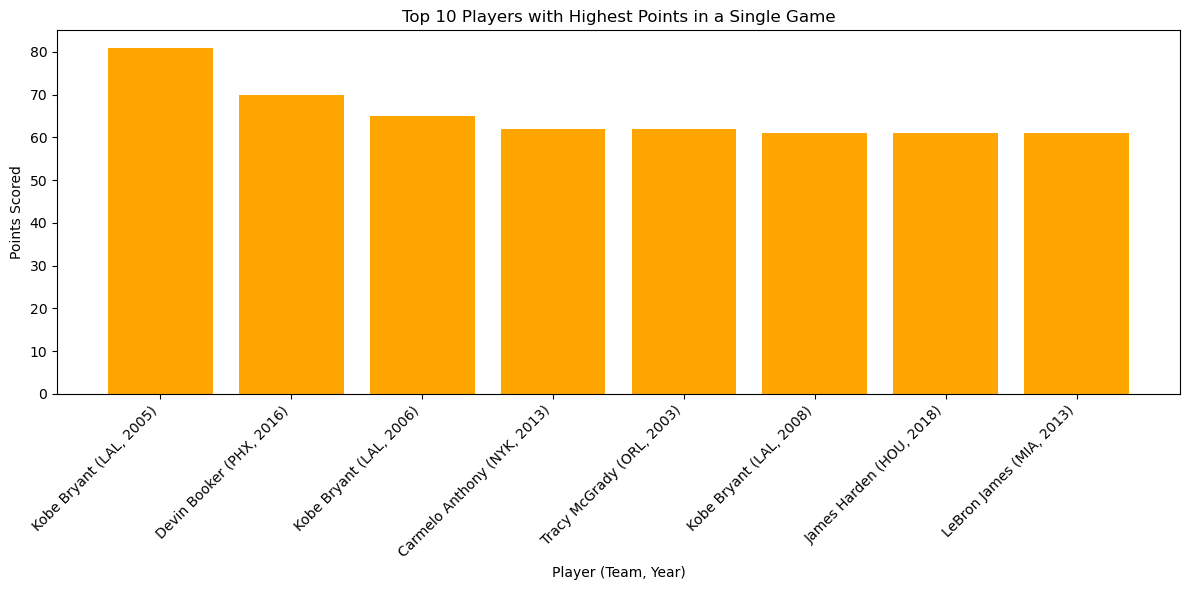

In [387]:
top_10_scorers = games_details_data.sort_values(by='PTS', ascending=False).head(10)


top_10_scorers_with_year = pd.merge(top_10_scorers, games_data[['GAME_ID', 'SEASON']], on='GAME_ID', how='left')


top_10_scorers_with_year['player_team_year'] = (
    top_10_scorers_with_year['PLAYER_NAME'] + ' (' + top_10_scorers_with_year['TEAM_ABBREVIATION'] + 
    ', ' + top_10_scorers_with_year['SEASON'].astype(str) + ')'
)



plt.figure(figsize=(12, 6))
plt.bar(top_10_scorers_with_year['player_team_year'], top_10_scorers_with_year['PTS'], color='orange')
plt.xlabel('Player (Team, Year)')
plt.ylabel('Points Scored')
plt.title('Top 10 Players with Highest Points in a Single Game')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

Here are the 10 Players with the highest point games




Here is the W/L ratio for at home teams over every game from 2003 to 2019

In [391]:


home_wins_count = games_data['HOME_TEAM_WINS'].sum()
home_losses_count = len(games_data) - home_wins_count 


home_win_percentage = (home_wins_count / (home_wins_count + home_losses_count)) * 100


print(f"Home Wins: {home_wins_count}")
print(f"Home Losses: {home_losses_count}")
print(f"Home Win Percentage: {home_win_percentage:.2f}%")

Home Wins: 13651
Home Losses: 9294
Home Win Percentage: 59.49%


There seems to be a clear advantage for at home teams. Over 20,000 games were played and the at home team won almost 60% of the time.

To calculate this i used the games dataset. There is a wins at home column where 0 means the home team lost and 1 means the home team won.
so I just counted how many 0's and 1's there are and calculated the at home win percentage from that.

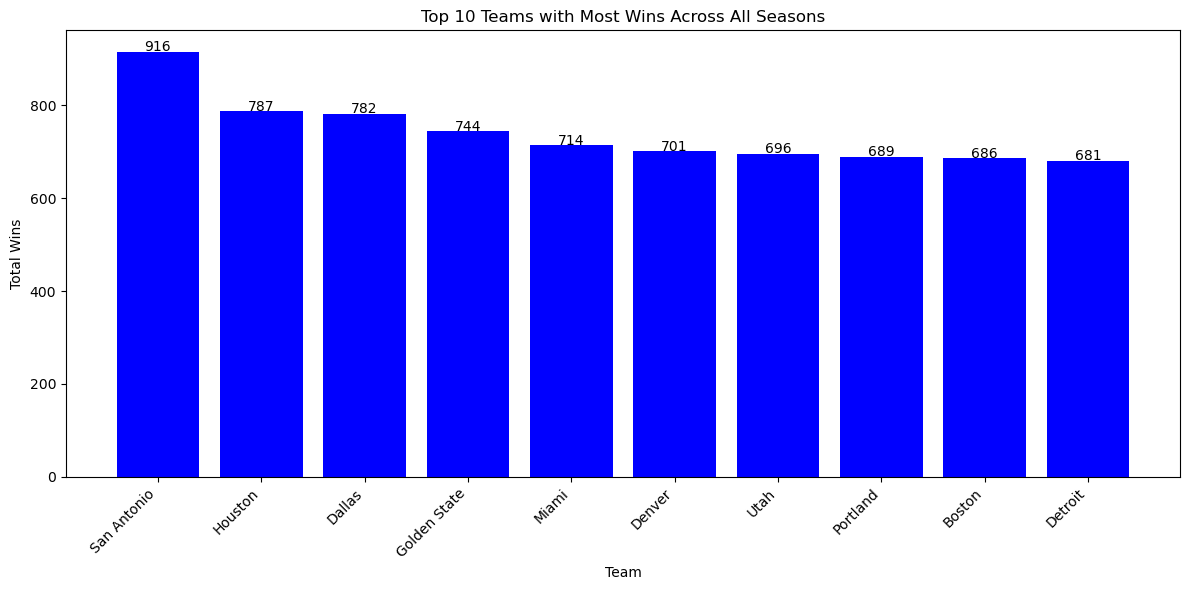

In [395]:
total_wins = ranking_data.groupby('TEAM')['W'].sum().reset_index()


top_10_teams = total_wins.sort_values(by='W', ascending=False).head(10)


plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_teams['TEAM'], top_10_teams['W'], color='blue')


for bar, wins in zip(bars, top_10_teams['W']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, str(int(wins)), 
             ha='center', va='bottom', color='black')

plt.xlabel('Team')
plt.ylabel('Total Wins')
plt.title('Top 10 Teams with Most Wins Across All Seasons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Here are the teams with the most combined wins from 2003-2019.

# Individual Player Rolling statistics

In [399]:
columns_to_average = [
    'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 
    'FT_PCT', 'OREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
    'PLUS_MINUS'
]


player_stats = games_details_data.groupby(['PLAYER_NAME', 'TEAM_ID'])[columns_to_average].mean().reset_index()


print(player_stats.head())


player_stats.to_csv('player_team_avg_stats.csv', index=False)

   PLAYER_NAME     TEAM_ID       FGM      FGA    FG_PCT      FG3M      FG3A   FG3_PCT       FTM       FTA    FT_PCT      OREB       REB       AST       STL       BLK        TO        PF       PTS  PLUS_MINUS
0  A.J. Guyton  1610612765  0.000000  4.00000  0.000000  0.000000  2.000000  0.000000  4.000000  4.000000  1.000000  1.000000  2.000000  1.000000  1.000000  0.000000  0.000000  2.000000  4.000000         NaN
1   AJ Hammons  1610612742  1.172414  2.62069  0.307724  0.172414  0.413793  0.132172  0.310345  0.689655  0.129310  0.482759  2.068966  0.241379  0.034483  0.551724  0.482759  1.172414  2.827586    0.068966
2   AJ Hammons  1610612748       NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN         NaN
3     AJ Price  1610612739  1.500000  4.12500  0.238313  0.500000  2.000000  0.121875  0.562500  0.875000  0.218750  0.375000  1.375000  1.375000  0.187500  0.000000  0

In [400]:
player_stats_with_nickname = pd.merge(
    player_stats, 
    teams_data[['TEAM_ID', 'NICKNAME']], 
    on='TEAM_ID', 
    how='left'
)



columns_order = ['PLAYER_NAME', 'NICKNAME'] + [col for col in player_stats_with_nickname.columns if col not in ['PLAYER_NAME', 'NICKNAME']]
player_stats_with_nickname = player_stats_with_nickname[columns_order]


print(player_stats_with_nickname.head())




   PLAYER_NAME      NICKNAME     TEAM_ID       FGM      FGA    FG_PCT      FG3M      FG3A   FG3_PCT       FTM       FTA    FT_PCT      OREB       REB       AST       STL       BLK        TO        PF       PTS  PLUS_MINUS
0  A.J. Guyton       Pistons  1610612765  0.000000  4.00000  0.000000  0.000000  2.000000  0.000000  4.000000  4.000000  1.000000  1.000000  2.000000  1.000000  1.000000  0.000000  0.000000  2.000000  4.000000         NaN
1   AJ Hammons     Mavericks  1610612742  1.172414  2.62069  0.307724  0.172414  0.413793  0.132172  0.310345  0.689655  0.129310  0.482759  2.068966  0.241379  0.034483  0.551724  0.482759  1.172414  2.827586    0.068966
2   AJ Hammons          Heat  1610612748       NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN         NaN
3     AJ Price     Cavaliers  1610612739  1.500000  4.12500  0.238313  0.500000  2.000000  0.121875  0.562500  0

Here I am combing the individual players stats and averaging them out. However, I am only combining the stats If that player stays on the same team. If they are moved to a different team then I created a new row for them using their data for the other team. A lot of players get traded and their performance can drastically change depending on where they go.

I want to know if the starters plus minus is better than players who come off the bench.

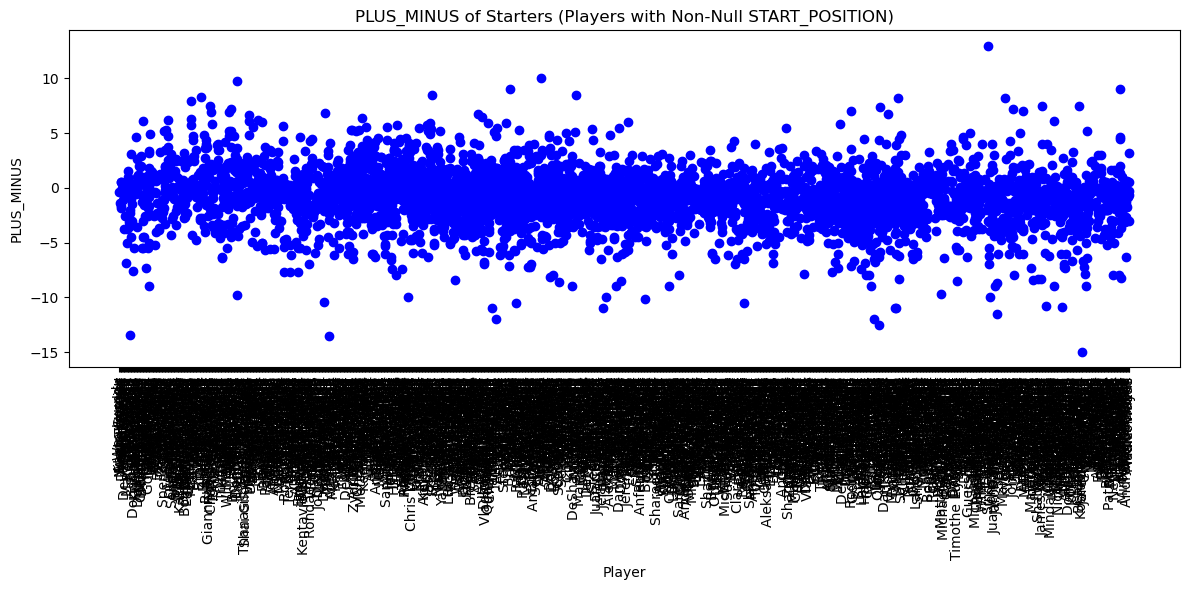

Mean PLUS_MINUS for Starters: -0.88


In [405]:
starters = games_details_data[games_details_data['START_POSITION'].notna()].drop_duplicates(subset='PLAYER_NAME')

starters_stats_with_plus_minus = pd.merge(
    starters[['PLAYER_NAME', 'PLAYER_ID']], 
    player_stats[['PLAYER_NAME', 'PLUS_MINUS']], 
    on='PLAYER_NAME', 
    how='left'
)

plt.figure(figsize=(12, 6))
plt.scatter(starters_stats_with_plus_minus['PLAYER_NAME'], starters_stats_with_plus_minus['PLUS_MINUS'], color='blue')
plt.xlabel('Player')
plt.ylabel('PLUS_MINUS')
plt.title('PLUS_MINUS of Starters (Players with Non-Null START_POSITION)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

mean_plus_minus_starters = starters_stats_with_plus_minus['PLUS_MINUS'].mean()
print(f"Mean PLUS_MINUS for Starters: {mean_plus_minus_starters:.2f}")


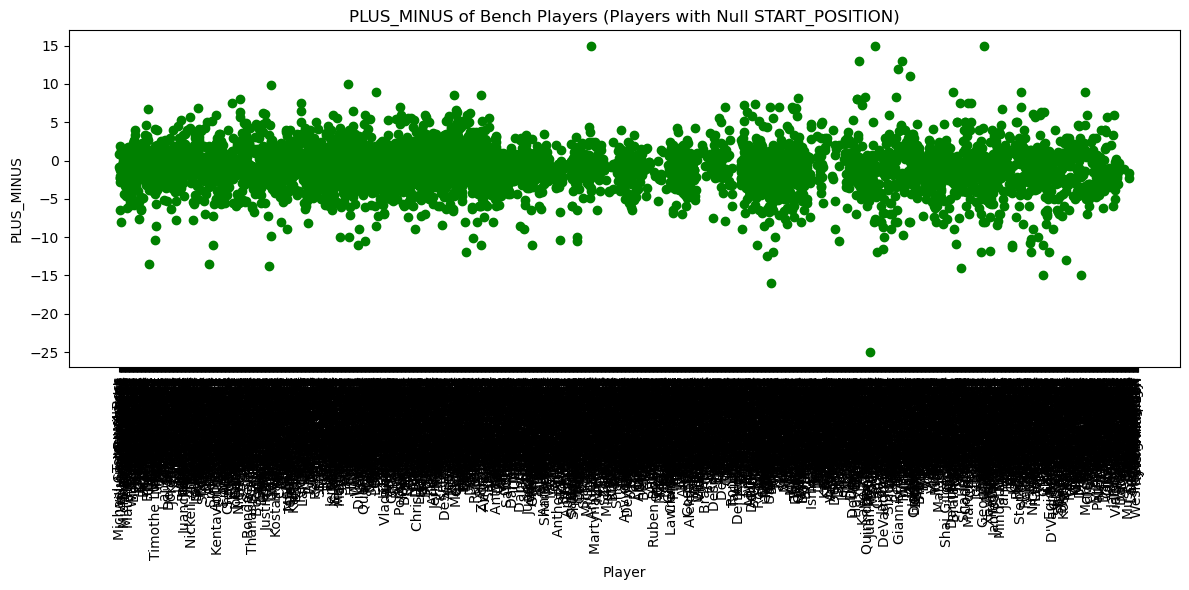

Mean PLUS_MINUS for Bench Players: -0.92


In [406]:
bench_players = games_details_data[games_details_data['START_POSITION'].isna()].drop_duplicates(subset='PLAYER_NAME')


bench_players_stats_with_plus_minus = pd.merge(
    bench_players[['PLAYER_NAME', 'PLAYER_ID']], 
    player_stats[['PLAYER_NAME', 'PLUS_MINUS']], 
    on='PLAYER_NAME', 
    how='left'
)




plt.figure(figsize=(12, 6))
plt.scatter(bench_players_stats_with_plus_minus['PLAYER_NAME'], bench_players_stats_with_plus_minus['PLUS_MINUS'], color='green')
plt.xlabel('Player')
plt.ylabel('PLUS_MINUS')
plt.title('PLUS_MINUS of Bench Players (Players with Null START_POSITION)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

mean_plus_minus_bench = bench_players_stats_with_plus_minus['PLUS_MINUS'].mean()
print(f"Mean PLUS_MINUS for Bench Players: {mean_plus_minus_bench:.2f}")

The starters have a better plus-minus than the bench players, but not as much as i thought. This might be because a lot of the time, opposing team's take out their starters at the same time. So it's Starters v starters, and then bench players v bench players so both teams are at a relatively similar skill level at all times.




# Methodology

My goal here is to see if there is a way to predict how many wins a team will get based of of team and player statistics.

Here im trying a few different ways of using the features I have selected for my KNN model. I Think that the features I have chosen are the most important statistics in basketball, so im going to test that here. 

In [411]:
playerstats = pd.read_csv('player_team_avg_stats.csv')
betterrankingdata = pd.read_csv('better_ranking_data.csv')

# Player Stats by Game

In [413]:
playerstats_features = games_details_data[['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 
                                    'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLUS_MINUS' ]]
ranking_features = betterrankingdata[[ 'TEAM_ID','SEASON', 'W']]

games_features = games_data[['GAME_ID', 'SEASON']]

first_merge = pd.merge(games_features, playerstats_features, on = 'GAME_ID')


In [414]:
#first_merge.to_csv('hahs.csv', index = False)

In [415]:
team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID', 'SEASON'], how = 'inner')

In [416]:
team_features = team_features.sort_values(by=['TEAM_ID', 'SEASON'], ascending=[True, True])

In [417]:
team_features.to_csv('hahs.csv', index = False)

In [418]:
team_features = team_features.dropna()

In [419]:
X = team_features.drop(columns=['W', 'TEAM_ID', 'SEASON', 'PLAYER_ID','GAME_ID'])
y = team_features['W']

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
knn = KNeighborsRegressor(n_neighbors=15)

knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [422]:
y_pred = knn.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


predicted_vs_actual = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_test})
print(predicted_vs_actual.head())

Mean Squared Error: 158.29355383348312
        Predicted Wins  Actual Wins
66889        41.800000           62
517319       38.133333           49
18084        41.133333           36
309935       44.466667           34
399422       43.466667           46


I originally thought this would be a good starting point but the model did not perform well at all. I used an 80-20 train-test split and I used n = 15 here because there is an average of 15 players on a single team, so i wanted to group each of them together. I got a MSE of 158, thats an error of about +-13. It's off by 13 games out of 82, which is a pretty significant error. I was trying to see if a team had a certain number of wins in a season, and you take a look at a random game to see how each player performed, would the total amount of wins for the season make sense. Apparently not. At least not with KNN, the model was completely useless for this kind of analysis. The error was very large inconsistent.

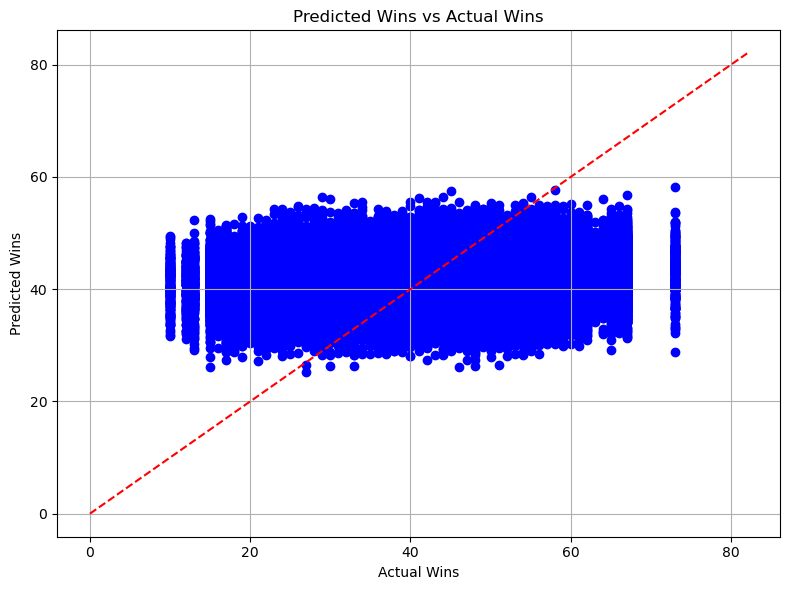

In [424]:
Actual = predicted_vs_actual['Actual Wins']
predicted = predicted_vs_actual['Predicted Wins']



plt.figure(figsize=(8, 6))
plt.scatter(Actual, predicted, color='blue')
plt.plot([0, 82], [0, 82], 'r--')  
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.grid(True)
plt.tight_layout()
plt.show()

# Individual Average by Season

In [427]:
playerstats_features = games_details_data[['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 
                                    'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLUS_MINUS' ]]
ranking_features = betterrankingdata[[ 'TEAM_ID','SEASON', 'W']]

games_features = games_data[['GAME_ID', 'SEASON']]

first_merge = pd.merge(games_features, playerstats_features, on = 'GAME_ID')

In [428]:
columns_to_average = [
    'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 'AST', 
    'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']


first_merge = first_merge.groupby(['PLAYER_ID', 'TEAM_ID', 'SEASON'])[columns_to_average].mean().reset_index()

In [429]:
#first_merge.to_csv('sda.csv', index = False)

In [430]:
team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID', 'SEASON'], how = 'inner')

In [431]:
team_features = team_features.sort_values(by=['TEAM_ID', 'SEASON'], ascending=[True, True])

In [432]:
#team_features.to_csv('sda.csv', index = False)

In [433]:
team_features = team_features.dropna()

In [434]:
X = team_features.drop(columns=['W', 'TEAM_ID', 'SEASON', 'PLAYER_ID'])
y = team_features['W']

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [436]:
knn = KNeighborsRegressor(n_neighbors=24)

knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=24)

In [437]:
y_pred = knn.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


predicted_vs_actual = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_test})
print(predicted_vs_actual.head())

Mean Squared Error: 94.15001116796621
      Predicted Wins  Actual Wins
5561       33.000000           36
2218       48.625000           53
2386       46.541667           54
517        42.083333           40
1631       50.750000           53


Here I tried seeing if the average stats for a teams players would prove more fruitful. I used an 80-20 train-test split and n = 24. 24 is out of the ordinary for a n value but i found it works the best since because with all the player trading that happens, there's an average of 24 people on a team's roster within any given season. Not all at the same time, but their statistics still matter for how that team performed. The model performed slightly better than my last attempt. With an MSE of 94.15. At this point I think using averages is the way to go but maybe not with individual players.

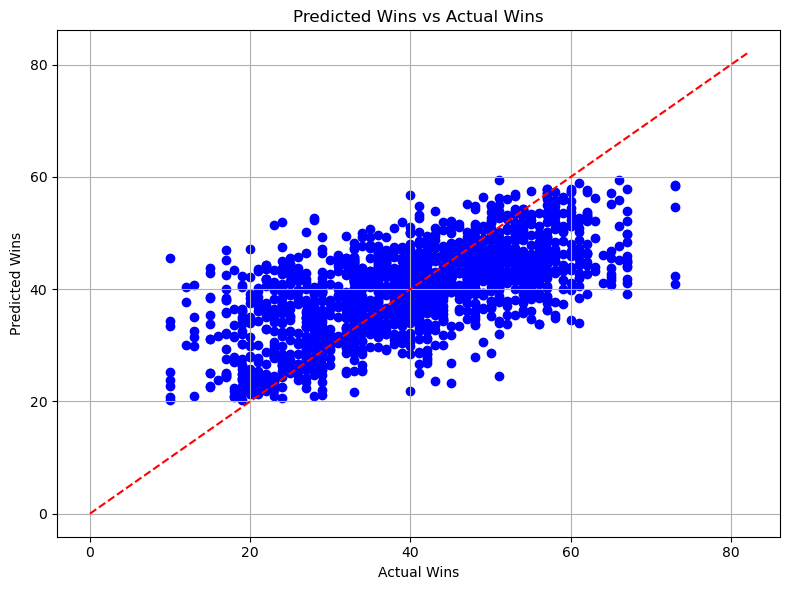

In [439]:
Actual = predicted_vs_actual['Actual Wins']
predicted = predicted_vs_actual['Predicted Wins']



plt.figure(figsize=(8, 6))
plt.scatter(Actual, predicted, color='blue')
plt.plot([0, 82], [0, 82], 'r--')  
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.grid(True)
plt.tight_layout()
plt.show()

# Team AVG by Season

In [618]:
playerstats_features = games_details_data[['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 
                                    'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLUS_MINUS' ]]
ranking_features = betterrankingdata[[ 'TEAM_ID','SEASON', 'W']]

games_features = games_data[['GAME_ID', 'SEASON']]

first_merge = pd.merge(games_features, playerstats_features, on = 'GAME_ID')
team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID', 'SEASON'], how = 'inner')

In [620]:
columns_to_average = [
    'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 'AST', 
    'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'W']


team_features = team_features.groupby(['TEAM_ID', 'SEASON'])[columns_to_average].mean().reset_index()

In [622]:
#team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID', 'SEASON'], how = 'inner')

In [624]:
team_features = team_features.sort_values(by=['TEAM_ID', 'SEASON'], ascending=[True, True])

In [626]:
#team_features = team_features.sort_values(by=['SEASON'], ascending=[True])

In [628]:
team_features.to_csv('erwwr.csv', index=False)

In [630]:
team_features = team_features.dropna()

In [632]:
X = team_features.drop(columns=['W', 'TEAM_ID', 'SEASON'])
y = team_features['W']

In [634]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [636]:

knn = KNeighborsRegressor(n_neighbors=15)

knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [638]:
y_pred = knn.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


predicted_vs_actual = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_test})
print(predicted_vs_actual.head())

Mean Squared Error: 13.035555555555554
     Predicted Wins  Actual Wins
284       55.600000         62.0
377       58.066667         54.0
117       59.800000         58.0
388       45.800000         50.0
70        36.800000         42.0


Here I used an 80-20 train-test split, and n=15. This model performed much better than the other two did. I took the average of the stats of every player on the team each season for each feature to use for my values. i used k = 15 because the data sets i used have data accross 15 seasons, so for each team there are 15 rows of data and i thought it would be best to group all of the teams seasons together. I actually found that k=24 has the lowest error at 11.99 instead of 13.04. I didn't know why since it would make the most sense that once you get to different teams, the avereages for each feature would be different. But with a little investigating, I found that every team is actually very balanced statistically speaking.

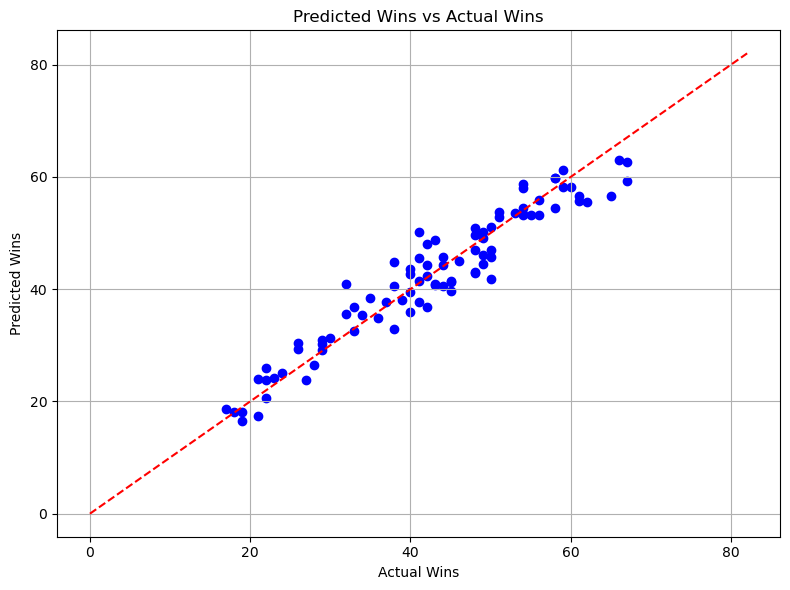

In [283]:

Actual = predicted_vs_actual['Actual Wins']
predicted = predicted_vs_actual['Predicted Wins']



plt.figure(figsize=(8, 6))
plt.scatter(Actual, predicted, color='blue')
plt.plot([0, 82], [0, 82], 'r--')  
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.grid(True)
plt.tight_layout()
plt.show()

# AVG Team statistics(03-19)

In [286]:
playerstats_features = games_details_data[['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 
                                    'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLUS_MINUS']]
ranking_features = betterrankingdata[[ 'TEAM_ID', 'W']]

games_features = games_data[['GAME_ID']]

first_merge = pd.merge(games_features, playerstats_features, on = 'GAME_ID')
team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID'], how = 'inner')

In [287]:
columns_to_average = [
    'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'OREB', 'AST', 
    'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'W']


team_features = team_features.groupby(['TEAM_ID'])[columns_to_average].mean().reset_index()

In [288]:
#team_features = pd.merge(ranking_features, first_merge, on=['TEAM_ID'], how = 'inner')

In [289]:
team_features = team_features.sort_values(by=['TEAM_ID'], ascending=[True])

In [290]:
team_features = team_features.dropna()

In [291]:
X = team_features.drop(columns=['W', 'TEAM_ID'])
y = team_features['W']

In [292]:
#team_features.to_csv('bla.csv', index=False)

In [293]:
#predicted_vs_actual.to_csv('blakk.csv', index=False)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [295]:
knn = KNeighborsRegressor(n_neighbors=1)

knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [296]:
y_pred = knn.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


predicted_vs_actual = pd.DataFrame({'Predicted Wins': y_pred, 'Actual Wins': y_test})
print(predicted_vs_actual.head())

Mean Squared Error: 2.810167824074074
    Predicted Wins  Actual Wins
27          38.875    36.562500
15          32.875    31.750000
23          44.625    44.125000
17          43.500    43.133333
8           46.500    49.187500


Here i just wanted to see how far i could go with the averages of team stats but theres no way this is actually right. I also used the average of the wins of each season for the teams. I combined all the averages for each season into one team statistic. This is about 15-16 years of data. I don't really know why this worked if im being honest. I used n=1 and a 80-20 split. 

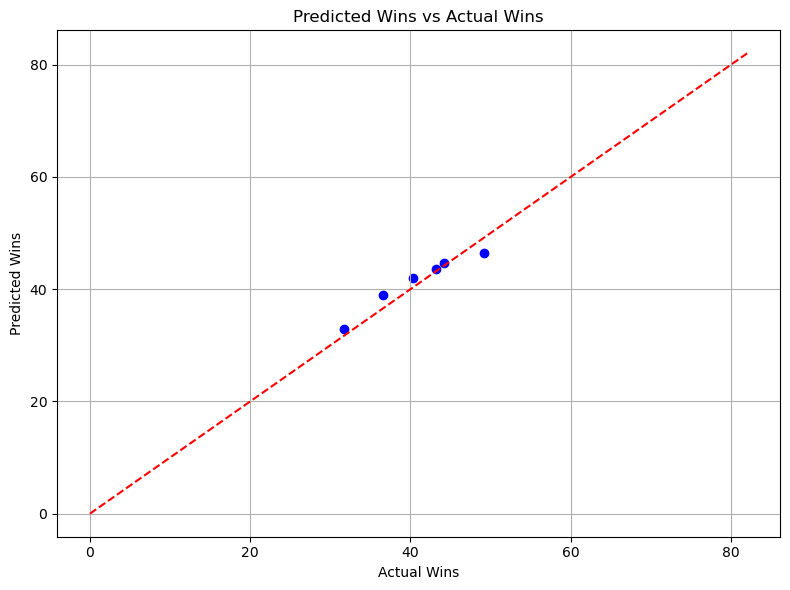

In [298]:
import matplotlib.pyplot as plt

# Assuming predicted vs actual data is available
Actual = predicted_vs_actual['Actual Wins']
predicted = predicted_vs_actual['Predicted Wins']



# Plotting Predicted vs Actual Wins
plt.figure(figsize=(8, 6))
plt.scatter(Actual, predicted, color='blue')
plt.plot([0, 82], [0, 82], 'r--')  
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted Wins vs Actual Wins')
plt.grid(True)
plt.tight_layout()
plt.show()

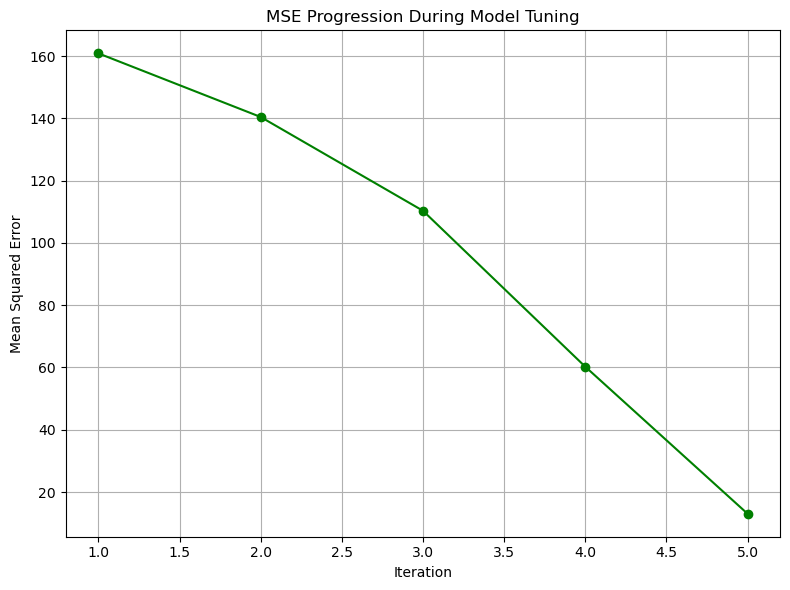

In [300]:
mse_values = [160.86, 140.43, 110.32, 60.25, 13.04]

# Plotting the MSE progression
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(mse_values)+1), mse_values, marker='o', color='green')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('MSE Progression During Model Tuning')
plt.grid(True)
plt.tight_layout()
plt.show()

The final KNN model achieved the following results: Mean Squared Error (MSE): 13.04, which translates to an average error of approximately 3.61 wins per team. Predicted Wins vs Actual Wins: The model predicted 55.6 wins for a team that won 62 games. Predicted 58.07 wins for a team that won 54 games, showing strong accuracy. Key Observations: The model accurately predicted the number of wins for teams with moderate win totals, but struggled somewhat with extremes (e.g., teams with very high or low win totals). The features related to home and road win percentages were particularly predictive of overall team success, as expected.

The KNN model demonstrated strong performance in predicting total NBA team wins, achieving a low MSE and making accurate predictions for most teams. Future improvements could include:

Additional Features: Incorporating individual player statistics, injuries, and coaching changes could improve the model’s predictive power. Alternative Models: Testing more complex models like Random Forest or Gradient Boosting may further enhance accuracy.

# Challenges

The only real challenge was feature selection. It took a lot of trial and error to find the best features to use. There was some difficulty choosing the correct value for n as well. There was a lot of time spent playing around with n and having to look directly in the tables to try to find the best value. I don't think KNN was the best choice either, since KNN relies on data proximity, there are just too many variables to account for in the NBA. The data sets i used gave me a little bit of trouble and they weren't as detailed as i hoped. I think before the final submission is due i am going to use an API to get the data from a more in depth source. 

# Next Steps

I found that using the average of all the players stats makes the model much more accurate. Every team seems pretty balanced when you do this though, so there's a reason outside of these feature's why some teams do better than others. My next move is probably to see if the star franchise players have anything to do with it. It might seem obvious that it would but basketball is a team sport, and as you can see by the results, It is more of a team game than an individual game. And I really think the ability for one person change the outcome of a game is more superstar level, and not every team has one of those so i dont know how much it will affect the results. I am also going to see if i can incorporate physical statistics of players. Basketball is a sport, so athleticism will no doubt play some part in a team's winning percentage. 
